## Child Ingredients

In this notebook I want to explore if there is any meaningful relationship between 'parent' and 'child' ingredients 
where a 'child' ingredient contains a subset of the 'parents' flavour compounds

In [22]:
from itertools import product
from utils import load_ingr_comps
import os
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib.pyplot as plt

In [2]:
# Load in the data
comp_info, ingr_info, ingr_comp = load_ingr_comps()

First I want to group by ingredient in the pairings table. This will then give a list of the compound ids for each
 ingredient id
 

In [3]:
comps_per_ingr = ingr_comp.groupby('# ingredient id')['compound id'].apply(set).to_frame()
comps_per_ingr['child_ing_names'] = [{} for i in range(len(comps_per_ingr))]
comps_per_ingr['child_ing_ids'] = [{} for i in range(len(comps_per_ingr))]
comps_per_ingr = comps_per_ingr.merge(ingr_info, left_index=True, right_index=True)
i = 0
for ing, row in comps_per_ingr.iterrows():
    if not i % 50:
        print(i)
    i+=1
    for ing2, row2 in comps_per_ingr.iterrows():
        if row['compound id'].issubset(row2['compound id']) and ing != ing2:
            comps_per_ingr.loc[ing2, 'child_ing_names'][row['ingredient name']] = len(row['compound id'])
            comps_per_ingr.loc[ing2, 'child_ing_ids'][ing] = len(row['compound id'])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500


In [4]:
# Sort each field in descending order by the number of compounds so that the most complet ingredients are displayed first
comps_per_ingr['child_ing_names'] = comps_per_ingr['child_ing_names'].apply(lambda x: sorted(x, key=x.get, reverse=True))
comps_per_ingr['child_ing_ids'] = comps_per_ingr['child_ing_ids'].apply(lambda x: sorted(x, key=x.get, reverse=True))

In [5]:
# Join the 'child' ingredients onto the ingredients
# Save the resulting 'child ingredients'
file_dir = os.path.dirname(os.path.abspath(""))
data_dir = os.path.join(file_dir, 'data/')
filepath = os.path.join(data_dir, 'child_ingrs.csv')
comps_per_ingr.to_csv(filepath)
comps_per_ingr.head()


,compound id,child_ing_names,child_ing_ids,ingredient name,category
0,{995},"[polyalthia_canangioides_flower, petasites_fra...","[146, 244, 349, 410, 440]",magnolia_tripetala,flower
1,{921},"[lindera_citriodora, leptospermum_liversidgei,...","[488, 517, 1294]",calyptranthes_parriculata,plant
2,{1018},"[while_thyme_oil, artemisia_frigida_oil]","[541, 1262]",chamaecyparis_pisifera_oil,plant derivative
3,"{769, 1028, 901, 902, 772, 645, 390, 391, 136,...","[sweetfish, eel, black_seabream, globefish, pi...","[264, 328, 366, 741, 1081, 1082, 1354, 1476, 8...",mackerel,fish/seafood
4,{964},[yellow_mombin],[144],mimusops_elengi_flower,flower


I would now like to build a Directed Tree graph that shows the most simple 'child ingredients' at the bottom and the more 
complex ones at the top. I can build the graph with networkx but before that some extra filtering is needed to remove unneccesacary connections.

E.g. B -> A indicates a child -> parent relationship. If B -> A and C -> B then it implies that C -> A. However because this is implied
in the graph I want to remove these connections so that it is easier to identify and useful structure.

A sibling ingredient can be defined as A -> B and B -> A or as having the same flavour compounds. These connections should stay.

In [8]:
def is_child(child1, child2, pruned_comps_per_ingr): 
    if child1 in pruned_comps_per_ingr.loc[child2, 'child_ing_ids']:
        return True
    else:
        return False

def is_sibling(child1, child2, pruned_comps_per_ingr):
    if pruned_comps_per_ingr.loc[child1, 'compound id'] == pruned_comps_per_ingr.loc[child2, 'compound id']:
        return True
    else:
        return False

# Add a 'Root' node to start the tree and aid the visualisation this root contains all of the ingredients as child ingredients (which will then be pruned)
comps_per_ingr.loc[-1] = [{}, [], list(comps_per_ingr.index.values), '', '']
try:
    comps_per_ingr.loc[-1, 'child_ing_ids'].remove(-1)
except ValueError:
    pass
    
pruned_comps_per_ingr = comps_per_ingr.copy()

i = 0
for ing, row in pruned_comps_per_ingr.iterrows():
    if not i % 50:
        print(i)
    i+=1
    for child1, child2 in product(row['child_ing_ids'], row['child_ing_ids']):
        if child1 == child2:
            continue
        if is_child(child1, child2, comps_per_ingr) and not is_sibling(child1, child2, comps_per_ingr):
            try:
                row['child_ing_ids'].remove(child1)
                need_to_continue = True
            except ValueError:
                continue


                
                

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500


In [9]:
            
filepath = os.path.join(data_dir, 'child_ingrs_pruned.csv')
comps_per_ingr.to_csv(filepath)
comps_per_ingr.head()

,compound id,child_ing_names,child_ing_ids,ingredient name,category
0,{995},"[polyalthia_canangioides_flower, petasites_fra...","[146, 244, 349, 410, 440]",magnolia_tripetala,flower
1,{921},"[lindera_citriodora, leptospermum_liversidgei,...","[488, 517, 1294]",calyptranthes_parriculata,plant
2,{1018},"[while_thyme_oil, artemisia_frigida_oil]","[541, 1262]",chamaecyparis_pisifera_oil,plant derivative
3,"{769, 1028, 901, 902, 772, 645, 390, 391, 136,...","[sweetfish, eel, black_seabream, globefish, pi...","[264, 328, 366, 741, 1081, 1082, 1354, 1476]",mackerel,fish/seafood
4,{964},[yellow_mombin],[144],mimusops_elengi_flower,flower


In [32]:
G = nx.DiGraph()

for ing, row in pruned_comps_per_ingr.iterrows():
    if row['ingredient name'] != '':
        G.add_node(row['ingredient name'])


for ing, row in pruned_comps_per_ingr.iterrows():
    for child_ing in row['child_ing_ids']:
        child_ing_name = pruned_comps_per_ingr.loc[child_ing, 'ingredient name']
    if row['ingredient name'] != '' and child_ing_name != '':
        G.add_edge(row['ingredient name'], child_ing_name)
            
            





In [33]:
filepath = 'child_ingrs_plot.dot'
nx.nx_pydot.write_dot(G,filepath)
# same layout using matplotlib with no labels

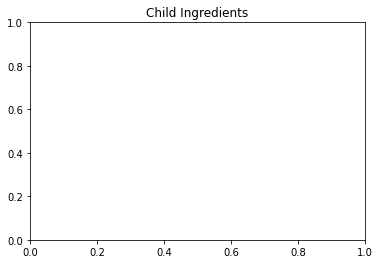

In [58]:
plt.title('Child Ingredients')
pos=graphviz_layout(G, prog='fdp')
plt.figure(figsize=(50, 50))
nx.draw(G, pos, with_labels=True, arrows=False)
plt.savefig('child_ingrs_plot.png')

In [45]:
raise ValueError
plt.title('Child Ingredients')
pos=graphviz_layout(G, prog='twopi')
plt.figure(figsize=(50, 50))
nx.draw(G, pos, with_labels=True, arrows=False)
plt.savefig('child_ingrs_plot_circular.png')

ValueError: 